In [4]:
import pandas as pd
import numpy as np
import gc

In [5]:
dtypes = {
        'ip'            : 'uint32',
        'app'           : 'uint16',
        'device'        : 'uint16',
        'os'            : 'uint16',
        'channel'       : 'uint16',
        'is_attributed' : 'uint8',
        'click_id'      : 'uint32',
        'hourofday'     : 'uint8',
        'dayofweek'     : 'uint8',
        'ip_device_os'  : 'uint32',
        'ip_device_os_app' : 'uint32',
        'ip_device_os_app_channel' :'uint32',
        }

In [103]:
def group_diff(garr, tarr, na_val=7200):
    #sidx = np.argsort(group_arr)
    #garr = group_arr[sidx]
    #tarr = target_arr[sidx]
    #print(tarr)
    grp_change = (garr[1:] != garr[:-1]) 
    #same_val = np.concatenate(([True], (tarr[1:] != tarr[:-1])))
    
    tarr_diff = np.diff(tarr)
    tarr_diff[grp_change] = na_val
    #print(tarr_diff)
    tarr_diff = np.concatenate(([na_val], tarr_diff))
    #print(np.argsort(sidx))
    return tarr_diff #tarr_diff[np.argsort(sidx)]
    
def group_agg(data):
    unq, ix, tags, count= np.unique(data, axis=0, 
                                    return_inverse=True, return_counts=True, return_index=True)
    cc = np.bincount(tags)
    diffs = group_diff(unq[:,0], unq[:, 1], 10**6)
    arr = np.c_[unq, cc, diffs][tags]
    return arr[:,2], arr[:,3]

def get_test_from_supp(test, test_supp, match_cols=[0,1], map_cols=[2,3]):
    unq, tags,  = np.unique(test[:,match_cols],  return_inverse=True, axis=0)
    unq2, idx2 = np.unique(test_supp[:, match_cols], return_index=True, axis=0)
    unq2 = np.c_[unq2, test_supp[idx2, :][:,map_cols]]
    
    test_unq = pd.merge( pd.DataFrame(unq, columns=match_cols),
              pd.DataFrame(unq2, columns=match_cols+map_cols), on=match_cols, how='left')
    test = test_unq.values[tags]
    return test

In [7]:
def read_prepare_data(input_path, col):
    df = pd.read_csv(input_path, usecols=[col, 'click_time'], dtype=dtypes)
    df['epoch_time'] = ((pd.to_datetime(df['click_time']) - pd.to_datetime("2017-11-06 14:00:00"))/10**9).astype(np.int64)
    del df['click_time']
    return df


def get_time_feats(TRAIN_PATH, TEST_PATH, TEST_SUPPLEMENT_PATH, col):
    train = read_prepare_data(TRAIN_PATH, col)
    test_supp = read_prepare_data(TEST_SUPPLEMENT_PATH, col)
    test = read_prepare_data(TEST_PATH, col)
    
    return train, test_supp, test
    

In [8]:
%%time
TRAIN_PATH = "../input/train_base.csv"
TEST_PATH = "../input/test_base.csv"
TEST_SUPPLEMENT_PATH = "../input/test_supplement_base.csv"
train, test_supp, test = get_time_feats(TRAIN_PATH, TEST_PATH, TEST_SUPPLEMENT_PATH, col='ip_device_os_app_channel')

CPU times: user 12min 16s, sys: 42.8 s, total: 12min 59s
Wall time: 14min 55s


In [9]:
print(train.shape, test.shape, test_supp.shape)
print(train.head())

(184903890, 2) (18790469, 2) (57537505, 2)
   ip_device_os_app_channel  epoch_time
0                  11619729        1941
1                  57333765        2014
2                  28378498        2052
3                  26941074        2092
4                  57956874        2108


In [10]:
train.tail()

,ip_device_os_app_channel,epoch_time
184903885,5954032,266400
184903886,57318973,266400
184903887,18167997,266400
184903888,63894883,266400
184903889,46153647,266400


In [11]:
gc.collect()

50

In [12]:
%%time
col = 'ip_device_os_app_channel'
data = np.vstack((train[[col,'epoch_time']].values, test_supp[[col,'epoch_time']].values))
ar1, ar2 = group_agg(data)

CPU times: user 17min 24s, sys: 1min 1s, total: 18min 26s
Wall time: 19min 46s


In [93]:
gc.collect()

3818

In [94]:
%%time
test.groupby(col)['epoch_time'].diff()

CPU times: user 18min 24s, sys: 37.3 s, total: 19min 2s
Wall time: 18min 43s


0               NaN
1               NaN
2               NaN
3               NaN
4               NaN
5               NaN
6               NaN
7               NaN
8               NaN
9               NaN
10              NaN
11              NaN
12              NaN
13              NaN
14              NaN
15              NaN
16              NaN
17              0.0
18              NaN
19              NaN
20              NaN
21              NaN
22              NaN
23              NaN
24              NaN
25              NaN
26              NaN
27              NaN
28              NaN
29              NaN
             ...   
18790439        NaN
18790440     2952.0
18790441     3296.0
18790442      382.0
18790443    18981.0
18790444        NaN
18790445     1236.0
18790446        NaN
18790447        NaN
18790448       32.0
18790449      152.0
18790450        NaN
18790451     4026.0
18790452        NaN
18790453      776.0
18790454        NaN
18790455        NaN
18790456       32.0
18790457        NaN


In [14]:
ar1[-100:], ar2[-100:]

(array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]),
 array([ 102039,   35904,   26436,      68, 1000000, 1000000,   42376,
        1000000,   13356,    4882,       2,      86, 1000000,   92618,
           4105, 1000000, 1000000, 1000000,  175373,    1307,      37,
        1000000,  277941,     463,   18850, 1000000,   47553, 1000000,
          11144, 1000000,   27943, 1000000,     281,    1268,       6,
        1000000,  110546,       1,       6,  144263,    4236,     131,
          42953,   38622,      11,   23420,    2252,   35597,     156,
             37,   28737,   10379, 1000000,     556,  127260,   22413,
          53138,      12,     154,      29,    2990, 1000000, 1000000,
           1925,   

In [15]:
ind = data[:,0] == 26925911
data[ind], ar1[ind], ar2[ind]

(array([[26925911,    28514],
        [26925911,    33477],
        [26925911,    34547],
        [26925911,    35412],
        [26925911,    35674],
        [26925911,    35756],
        [26925911,    73735],
        [26925911,    74766],
        [26925911,    80366],
        [26925911,    85665],
        [26925911,    86414],
        [26925911,    90958],
        [26925911,   122176],
        [26925911,   150513],
        [26925911,   155068],
        [26925911,   166419],
        [26925911,   170758],
        [26925911,   173902],
        [26925911,   182699],
        [26925911,   184483],
        [26925911,   184893],
        [26925911,   234112],
        [26925911,   243664],
        [26925911,   243827],
        [26925911,   245353],
        [26925911,   246818],
        [26925911,   255216],
        [26925911,   255216],
        [26925911,   257542],
        [26925911,   292981],
        [26925911,   296022],
        [26925911,   298501],
        [26925911,   301410],
        [2

In [16]:
%%time
train['ip_device_os_app_channel_timecount'] = ar1[:len(train)]
test_supp['ip_device_os_app_channel_timecount'] = ar1[len(train):]

train['ip_device_os_app_channel_timediff'] = ar2[:len(train)]
test_supp['ip_device_os_app_channel_timediff'] = ar2[len(train):]

print(train.shape, test_supp.shape)
del ar1, ar2

(184903890, 4) (57537505, 4)
CPU times: user 2.2 s, sys: 1.91 s, total: 4.11 s
Wall time: 4.63 s


In [17]:
gc.collect()

21

In [18]:
test_supp.tail()

,ip_device_os_app_channel,epoch_time,ip_device_os_app_channel_timecount,ip_device_os_app_channel_timediff
57537500,63278090,352800,1,336
57537501,41257596,352800,1,17925
57537502,57935984,352800,1,13726
57537503,26738194,352800,1,64
57537504,26925911,352800,1,6848


In [104]:
test = get_test_from_supp(test.values, test_supp.values)
test[:10]

array([[47945368,   309600,        1,       16],
       [16240070,   309600,        1,     2270],
       [ 3390926,   309600,        1,      157],
       [ 7284632,   309600,        1,   136665],
       [40088629,   309600,        1,     3282],
       [12893412,   309600,        1,     2133],
       [22743412,   309600,        1,  1000000],
       [18954314,   309600,        1,     6551],
       [34337064,   309600,        1,    99926],
       [65706700,   309600,        1,  1000000]])

In [105]:
len(test)

18790469

In [106]:
test = pd.DataFrame(test, columns=train.columns)
test.head()

,ip_device_os_app_channel,epoch_time,ip_device_os_app_channel_timecount,ip_device_os_app_channel_timediff
0,47945368,309600,1,16
1,16240070,309600,1,2270
2,3390926,309600,1,157
3,7284632,309600,1,136665
4,40088629,309600,1,3282


In [107]:
feats = ['ip_device_os_app_channel_timecount', 'ip_device_os_app_channel_timediff']
train[feats].to_pickle("../output/train_time5.pkl")
test[feats].to_pickle("../output/test_time5.pkl")

In [63]:
del train
del test
del test_supp

array([0, 1, 4, 6, 3])

In [52]:
%%time
COL = 'ip_device_os_app'
train, test_supp, test = get_time_feats(TRAIN_PATH, TEST_PATH, TEST_SUPPLEMENT_PATH, col=COL)
ar1, ar2 = group_agg(pd.concat([train, test_supp]), COL)
train[COL+'_timecount'] = ar1[:len(train)]
test_supp[COL+'_timecount'] = ar1[len(train):]

train[COL+'_timediff'] = ar2[:len(train)]
test_supp[COL+'_timediff'] = ar2[len(train):]

del ar1, ar2

test = get_test_from_supp(test, test_supp)

feats = [COL+'_timecount', COL+'_timediff']
train[feats].to_pickle("../output/train_time4.pkl")
test[feats].to_pickle("../output/test_time4.pkl")

del train
del test
del test_supp

CPU times: user 5.81 s, sys: 4.45 ms, total: 5.81 s
Wall time: 5.81 s


In [53]:
ts = test['ip_device_os_app_channel'].values[sidx]

In [54]:
ts[1:] != ts[:-1]

array([ True, False, False, ...,  True,  True, False])

In [57]:
tt = np.array([0, 0, 1, 1, 1, 2, 2, 3])

In [66]:
m = np.concatenate(((tt[1:] != tt[:-1])))
m

array([ True, False,  True, False, False,  True, False,  True])

In [62]:
aa = np.array([1,2,3,4,5,6,7,8])

In [71]:
d = np.concatenate(([aa[0]], np.diff(aa)))
d[m] = -1
d

array([-1,  1, -1,  1,  1, -1,  1, -1])

In [73]:
a = np.array([3,2,1,4])
an = np.argsort(a)
print(an)
print(a[an])
print(np.sort(an))
print(a[np.sort(an)])

[2 1 0 3]
[1 2 3 4]
[0 1 2 3]
[3 2 1 4]


In [168]:
%%time
group_agg(test, 'ip_device_os_app_channel')

CPU times: user 47.4 s, sys: 3.65 s, total: 51.1 s
Wall time: 51 s


(array([1, 1, 1, ..., 1, 1, 1]),
 array([1000000,     352, 1000000, ..., 1000000, 1000000, 1000000]))

In [112]:
tt = np.array([3, 0, 1, 0, 1, 2, 2, 2, 2, 1])
aa = np.array([1, 2, 3, 4, 5, 6, 7, 8, 8, 8])
dd = group_diff(tt, aa)
dd

array([7200, 7200, 7200,    2,    2, 7200,    1,    1,    0,    3])

In [135]:
unq, tags, count = np.unique(test['ip_device_os_app_channel'].values, return_inverse=1, return_counts=1)
cnt_vals = np.bincount(tags)
np.c_[np.repeat(unq, count), np.repeat(count, count)]

array([[       5,        1],
       [      15,        3],
       [      15,        3],
       ...,
       [66451033,        1],
       [66451048,        2],
       [66451048,        2]])

In [162]:
a = np.array([1,2,3,2,1,4,1,5,2,5])
b = np.array([1,2,2,2,2,3,4,4,4,5])

unq, ix, tags, count= np.unique(list(zip(a,b)), axis=0, return_inverse=True, return_counts=True, return_index=True)

unq, ix, tags, count

(array([[1, 1],
        [1, 2],
        [1, 4],
        [2, 2],
        [2, 4],
        [3, 2],
        [4, 3],
        [5, 4],
        [5, 5]]),
 array([0, 4, 6, 1, 8, 2, 5, 7, 9]),
 array([0, 3, 5, 3, 1, 6, 2, 7, 4, 8]),
 array([1, 1, 1, 2, 1, 1, 1, 1, 1]))

In [163]:
cc = np.bincount(tags)
np.repeat(cc, repeats=cc, axis=0)

array([1, 1, 1, 2, 2, 1, 1, 1, 1, 1])

In [164]:
diffs = group_diff(unq[:,0], unq[:, 1])
diffs

array([7200,    1,    2, 7200,    2, 7200, 7200, 7200,    1])

In [165]:
np.repeat(np.c_[unq, cc, diffs], cc, axis=0)[ix]

array([[   1,    1,    1, 7200],
       [   2,    2,    2, 7200],
       [   3,    2,    1, 7200],
       [   1,    2,    1,    1],
       [   5,    4,    1, 7200],
       [   1,    4,    1,    2],
       [   2,    4,    1,    2],
       [   4,    3,    1, 7200],
       [   5,    5,    1,    1]])

In [87]:
%%time
#tmp = group_diff(test['ip_device_os_app_channel'].values, test['epoch_time'], na_val=10**6)

[       0        1        2 ... 18790466 18790467 18790468]
CPU times: user 18.9 s, sys: 1.42 s, total: 20.4 s
Wall time: 20.4 s


In [130]:
np.repeat(np.array([1,2,2,3]), [2,1,2,2])

array([1, 1, 2, 2, 2, 3, 3])

In [46]:
np.flatnonzero(m).shape

(10247997,)

In [47]:
t.shape

(18790469,)

In [31]:
m = np.concatenate(( m0, [True]))

In [40]:
m0

array([ True, False, False, ...,  True,  True, False])

In [34]:
np.flatnonzero()

(18790469,)

In [1]:
test_supp = pd.read_csv("../input/test_supplement_base.csv", usecols=['ip_device_os_app_channel', 'click_time'], dtype=dtypes)

NameError: name 'pd' is not defined

In [51]:
test_supp['epoch_time'] = ((pd.to_datetime(test_supp['click_time']) - pd.to_datetime("2017-11-06 14:00:00"))/10**9).astype(np.int64)

In [52]:
del test_supp['click_time']

In [39]:
np.all(test_supp['epoch_time'].values ==  test_supp['epoch_time'].sort_values().values)

True

In [55]:
test_supp.duplicated().sum()

1000667

In [61]:
test_supp['dummy'] = 1

In [ ]:
test = pd.merge(test, test_supp.drop_duplicates(), on=['ip_device_os_app_channel', 'epoch_time'], how='left')
test.head()

In [65]:
test.shape

(20797412, 3)

In [42]:
test_supp[test_supp['epoch_time'] >= 349200].shape

(2953745, 2)

In [49]:
test_supp[(test_supp['epoch_time'] <= 349200) & (test_supp['epoch_time'] >= 309600)].shape

(33294289, 2)

In [ ]:
test_supp

In [57]:
df.groupby(['ip','device','os'])['epoch_time'].diff().describe()

count    866122.000000
mean          0.657380
std           1.976924
min           0.000000
25%           0.000000
50%           0.033333
75%           0.250000
max          90.433333
Name: epoch_time, dtype: float64

In [58]:
import matplotlib.pyplot as plt
import seaborn as sns

In [59]:
tmp = df2.groupby(['ip','device','os']).apply(lambda x: x['epoch_time'].diff())
tmp

ip      device  os        
9       1       13  136178         NaN
                    145734    0.183333
10      1       22  343557         NaN
20      1       10  998194         NaN
                13  820623         NaN
                    984013    3.900000
25      1       13  328270         NaN
                    328282    0.000000
                    371311    0.883333
                    374091    0.050000
                    480071    2.333333
                    479925    0.000000
                    549571    1.583333
                    549539    0.000000
                    652614    2.383333
                18  301564         NaN
27      1       13  430695         NaN
                    430663    0.000000
                    547438    2.633333
                    678126    3.050000
                    703169    0.583333
                    703170    0.000000
                    761864    1.400000
                22  312579         NaN
                    312753    0.00000

In [60]:
tmp.index.names

FrozenList(['ip', 'device', 'os', None])

In [61]:
tmp2 = tmp.reset_index(level=[0,1,2]).sort_index()
tmp2

,ip,device,os,epoch_time
0,83230,1,13,NaN
1,17357,1,19,NaN
2,35810,1,13,NaN
3,45745,1,13,NaN
4,161007,1,13,NaN
5,18787,1,16,NaN
6,103022,1,23,NaN
7,114221,1,19,NaN
8,165970,1,13,NaN
9,74544,1,22,NaN


In [69]:
df['user_click_diff'] = tmp2['epoch_time']

In [70]:
df.loc[df.ip == 87540].sort_values(['click_time'])

,ip,app,device,os,channel,click_time,attributed_time,is_attributed,epoch_time,user_click_diff
65879,87540,12,1,13,265,2017-11-06 16:01:10,NaN,0,88.816667,NaN
67164,87540,3,1,13,280,2017-11-06 16:01:11,NaN,0,88.833333,0.016667
172871,87540,2,1,22,237,2017-11-06 16:03:14,NaN,0,90.883333,NaN
279542,87540,8,1,17,145,2017-11-06 16:05:24,NaN,0,93.050000,NaN
280759,87540,15,1,17,140,2017-11-06 16:05:25,NaN,0,93.066667,0.000000
280967,87540,1,1,17,134,2017-11-06 16:05:25,NaN,0,93.066667,0.000000
281490,87540,8,1,17,145,2017-11-06 16:05:25,NaN,0,93.066667,0.000000
281674,87540,9,1,17,134,2017-11-06 16:05:25,NaN,0,93.066667,0.016667
282713,87540,8,1,17,145,2017-11-06 16:05:26,NaN,0,93.083333,0.016667
448402,87540,3,1,19,280,2017-11-06 16:08:50,NaN,0,96.483333,NaN


In [64]:
df.loc[df.ip == 87540].sort_values(['click_time'])['epoch_time'].diff()

65879          NaN
67164     0.016667
172871    2.050000
279542    2.166667
280759    0.016667
280967    0.000000
281490    0.000000
281674    0.000000
282713    0.016667
448402    3.400000
449392    0.016667
450536    0.016667
450930    0.016667
452286    0.033333
633219    4.133333
633669    0.000000
633846    0.016667
634152    0.000000
640799    0.150000
653586    0.300000
668479    0.366667
Name: epoch_time, dtype: float64

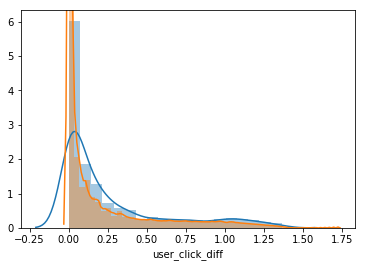

In [83]:
sns.distplot(np.log1p(np.log1p(df.loc[df.is_attributed ==1, "user_click_diff"].dropna())))
sns.distplot(np.log1p(np.log1p(df.loc[df.is_attributed ==0, "user_click_diff"].dropna())))
plt.show()

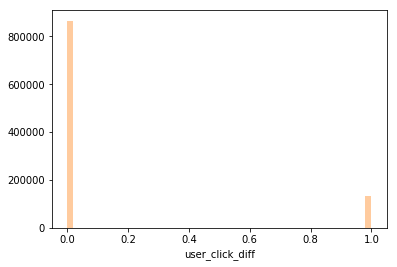

In [82]:
sns.distplot(df.loc[df.is_attributed ==1, "user_click_diff"].isnull().astype(int), kde=False)
sns.distplot(df.loc[df.is_attributed ==0, "user_click_diff"].isnull().astype(int), kde=False)
plt.show()

In [84]:
def get_epoch_diff(df_sorted, cols): #Needs epoch_time column
    col_name =  "click_diff"
    tmp = df_sorted.groupby(cols).apply(lambda x: x['epoch_time'].diff())
    tmp.name = col_name
    tmp = tmp.reset_index(level=[0,1,2]).sort_index()
    
    return tmp[col_name]
    

In [85]:
get_epoch_diff(df2, ['ip', 'device'])

0               NaN
1          0.183333
2               NaN
3               NaN
4          3.900000
5          0.316667
6               NaN
7          0.483333
8          0.000000
9          0.883333
10         0.050000
11         2.333333
12         0.000000
13         1.583333
14         0.000000
15         2.383333
16              NaN
17         0.000000
18         0.000000
19         0.000000
20         2.450000
21         0.000000
22         2.633333
23         3.050000
24         0.583333
25         0.000000
26         0.133333
27         0.016667
28         0.000000
29         0.000000
            ...    
999970     0.000000
999971     0.000000
999972          NaN
999973    16.733333
999974     0.950000
999975     1.050000
999976          NaN
999977          NaN
999978     3.016667
999979     0.016667
999980     7.500000
999981     0.416667
999982     5.050000
999983          NaN
999984          NaN
999985     0.816667
999986     0.000000
999987     1.550000
999988     0.216667


In [107]:
import gc
def get_epoch_diff2(df_sorted, cols): #Needs epoch_time column
    col_name =  "click_diff"
    n = len(cols)
    tmps = []
    for (i, grp) in df_sorted.groupby(cols):
        tmp = grp['epoch_time'].diff()
        tmps.append(tmp)
        gc.collect()
        print(i)
    tmps = pd.concat(tmps).sort_index()
    tmps.name = col_name
    tmps = tmps.reset_index(level=list(range(n-1))).sort_index()
    return tmps[col_name]

In [ ]:
get_epoch_diff2(df2, ['ip', 'device'])

(9, 1)
(10, 1)
(20, 1)
(25, 1)
(27, 1)
(31, 1)
(36, 1)
(39, 0)
(39, 1)
(45, 1)
(52, 1)
(59, 1)
(59, 3032)
(60, 1)
(61, 1)
(63, 1)
(81, 1)
(83, 1)
(85, 1)
(88, 1)
(92, 1)
(92, 2)
(92, 3032)
(95, 1)
(113, 1)
(117, 1)
(117, 3032)
(120, 1)
(122, 1)
(122, 2)
(126, 1)
(133, 1)
(150, 0)
(150, 1)
(151, 1)
(165, 0)
(165, 1)
(167, 1)
(169, 1)
(176, 1)
(177, 1)
(195, 1)
(195, 2)
(196, 1)
(198, 1)
(198, 2)
(198, 3032)
(203, 1)
(209, 0)
(209, 1)
(209, 2)
(212, 1)
(219, 1)
(220, 1)
(222, 1)
(222, 2)
(231, 1)
(231, 2)
(232, 1)
(235, 1)
(246, 1)
(247, 1)
(248, 1)
(254, 1)
(255, 1)
(255, 2)
(259, 1)
(268, 1)
(268, 2)
(279, 1)
(279, 2)
(280, 1)
(282, 1)
(282, 2)
(283, 1)
(288, 1)
(288, 2)
(301, 1)
(302, 1)
(302, 3032)
(315, 1)
(324, 1)
(327, 1)
(340, 1)
(341, 1)
(344, 1)
(346, 1)
(353, 1)
(365, 1)
(368, 1)
(381, 1)
(381, 2)
(392, 1)
(394, 1)
(405, 1)
(407, 1)
(411, 1)
(424, 1)
(424, 2)
(432, 1)
(433, 1)
(439, 1)
(440, 1)
(444, 0)
(444, 1)
(445, 1)
(464, 1)
(464, 3032)
(466, 1)
(470, 3032)
(472, 1)
(472,

(4548, 1)
(4553, 1)
(4559, 1)
(4560, 1)
(4563, 1)
(4565, 1)
(4565, 3032)
(4567, 1)
(4570, 1)
(4571, 1)
(4573, 1)
(4573, 2)
(4577, 1)
(4577, 122)
(4600, 1)
(4600, 3032)
(4602, 1)
(4608, 1)
(4617, 1)
(4623, 1)
(4623, 2)
(4626, 1)
(4629, 0)
(4629, 1)
(4630, 1)
(4633, 0)
(4633, 1)
(4643, 1)
(4643, 3032)
(4646, 1)
(4649, 1)
(4652, 0)
(4652, 1)
(4653, 1)
(4664, 1)
(4670, 1)
(4676, 0)
(4676, 1)
(4678, 1)
(4678, 3032)
(4680, 1)
(4683, 1)
(4683, 2)
(4689, 1)
(4690, 1)
(4693, 1)
(4693, 3032)
(4700, 1)
(4701, 1)
(4720, 1)
(4722, 1)
(4724, 1)
(4727, 1)
(4729, 1)
(4737, 1)
(4737, 2)
(4738, 1)
(4740, 1)
(4741, 1)
(4741, 2)
(4744, 1)
(4754, 1)
(4759, 1)
(4763, 1)
(4764, 1)
(4769, 1)
(4769, 2)
(4777, 1)
(4779, 1)
(4784, 1)
(4789, 1)
(4803, 1)
(4806, 1)
(4820, 1)
(4825, 1)
(4830, 1)
(4833, 1)
(4841, 1)
(4846, 1)
(4846, 6)
(4855, 1)
(4856, 1)
(4862, 0)
(4862, 1)
(4862, 2)
(4862, 3032)
(4863, 1)
(4863, 2)
(4863, 114)
(4868, 1)
(4869, 1)
(4875, 1)
(4876, 1)
(4876, 2)
(4883, 1)
(4886, 1)
(4886, 3032)
(4889

In [92]:
df2.columns

Index(['ip', 'app', 'device', 'os', 'channel', 'click_time', 'attributed_time',
       'is_attributed', 'epoch_time'],
      dtype='object')